# Bats classification with PyTorch Ligthning

# 1. Setup
## 1.1. Import libraries

In [3]:
#read CSV
import pandas as pd

#move data
import os
import shutil

#reconcile labels - images
import glob

#visualisation
import matplotlib.pyplot as plt
%matplotlib inline

#data splitter
from sklearn.model_selection import train_test_split

#Downsampling
from sklearn.utils import resample

#Upsampling
import augly.image as imaugs
import torchvision.transforms as transforms
from PIL import Image
import random

#Logger
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

#model
import flash
from flash import Trainer
from flash.audio import AudioClassificationData
from flash.image import ImageClassifier
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint

#confusion Matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

/home/wustl/VideoClassifier/.menv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1. Set training variables
- define variables, to optimize the model

In [4]:
class tparams:
    epochs=20
    batch_size=50
    backbone="efficientnet_l2"   
    strategy="freeze"
    resample_augmentation="stripes_opac" #no impact. Just for output to hyperparams
    test_run_name=f"ds_y:ups_{resample_augmentation}+25%:freeze:epo{epochs}:{backbone}" #for logger

#"efficientnet_l2" bat_resnext26ts 'vgg19' 'resnet152 34 50' 'densenet201' inception_v4 xception 'efficientnet_b3'

#strategy=("unfreeze_milestones", ((3, 8), 2)) 
#backbone starts frozen,at epoch 3 the last 2 layers unfreeze, at epoch 8 the full backbone unfreezes

#strategy=("freeze_unfreeze", 7) -> unfreeze after epoche 7

#max batch size 4.736

## 1.2. Define paths for input data

In [5]:
#paths images
src_1 = "/home/wustl/bats_classification/Bat_Orientation_Calls"
src_2 = "/home/wustl/bats_classification/LMU_20180326_png"
src_3 = "/home/wustl/bats_classification/Bat_Orienatation_Calls_3"

src = [src_1, src_2, src_3] #list image sources

#paths labels
src_labels_1 = "./Bat_Orientation_Calls/Auswertung_20220524.csv"
src_labels_2 = "./Bat_Orientation_Calls_2/LMU_20180326_class.csv"
src_labels_3 = "./Bat_Orienatation_Calls_3/LMU_20180505_classified.csv"

# 2. Global Functions
## 2.1. Global functions for plot

In [6]:
def plot_col(df, col):
    """Plots the col of the input df"""
    ax = df[col].value_counts().plot(kind='bar',
                                        figsize=(10,4),
                                        title="Distribution of images per class")
    ax.set_xlabel("Class")
    ax.set_ylabel("Number of records")
    plt.show()
    
def plot_model_acc(train_acc, valid_acc, save_dir):
    """Plots train and validation accuracy per epoch"""
    fig = plt.figure(figsize=(12, 8))
    plt.grid(True)
    plt.plot(train_acc, color="r", marker="o", label='train/acc')
    plt.plot(valid_acc, color="b", marker="x", label='valid/acc')
    plt.ylabel('Accuracy', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.legend(loc='lower right', fontsize=16)
    plt.title('Training and Validation Accuracy', fontsize=20)
    plt.savefig(f'{save_dir}/acc.png')
    plt.show()

def plot_model_loss(train_loss, valid_loss, save_dir):
    """Plots train and validation loss per epoch"""
    fig = plt.figure(figsize=(12, 8))
    plt.grid(True)
    plt.plot(train_loss, color="r", marker="o", label='train/loss')
    plt.plot(valid_loss, color="b", marker="x", label='valid/loss')
    plt.ylabel('Loss', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.legend(loc='upper right', fontsize=16)
    plt.title('Training and Validation Loss', fontsize=20)
    plt.savefig(f'{save_dir}/loss.png')
    plt.show()
    
def plot_confusion_matrix(cm, classes, save_dir):
    """Defines confusion matrix in absolute and relative numbers"""
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharex=True, sharey=True)
    ax1.title.set_text('Absolut')
    ax2.title.set_text('Relative')
    fig.text(0.5, 0, 'Predicated Label', ha='center', fontsize=14)
    fig.text(0, 0.5, 'True label', va='center', rotation='vertical', fontsize=14)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, ax=ax1, cmap="YlGnBu")
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, ax=ax2, cmap="YlGnBu")

    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png')
    plt.show()

## 2.2. Global functions for resampling

In [7]:
def downsample_data(train, column:str=None):
        """Downsamples the largest group to match the second largest group"""
        values_of_col = dict(train[column].value_counts())
        key_max = max(values_of_col, key=values_of_col.get)
        max_value = max(values_of_col.values())
        value_max2 = 0
        for v in values_of_col.values():
             if(v>value_max2 and v<max_value):
                    value_max2 = v

        df_max = train[train[column]== key_max]
        df_rest = train[train[column]!= key_max]

        df_max_downsample = resample(df_max,
                                        replace = False, #sample without replacement
                                        n_samples = value_max2, #match second largest group
                                        random_state = 27) #reproducible results

        #combine minority and downsampled majority and set to train df
        train = pd.concat([df_max_downsample, df_rest])
        return train

def upsample_data(df, column:str=None, outputpath:str=None):
    """Takes a dataframe and upsamples the data based on the col.
    The upsample techniques are choosen at randome.
    """
    values_of_col = dict(df[column].value_counts())
    
    #key_max = max(values_of_col, key=values_of_col.get)
    data = list(values_of_col.values())
    data.sort()
    key_max = data[-2]
    new_data_store = []
    for key, value in values_of_col.items():
        counter = 0

        while value <= key_max-values_of_col[key]: #*1.25
            counter +=1 
            mem_df = df.loc[df[column]==key]
            for path in mem_df["new_filename"].to_list():
                new_data_store.append([key,augment_data(path,outputpath,counter)])
                value+=1
                if value == key_max-values_of_col[key]: #*1.25
                    break   
    return new_data_store

def augment_data(input_path, out_path, run_count):
    """The input data will be augmented and transformed to the output data"""
    """AugLy paper: https://artofrobust.github.io/long_paper/12.pdf"""
    input_img = Image.open(input_path)
    file_name = input_path.split("/")[-1]
    aug = transforms.Compose(
        [   #imaugs.RandomNoise(mean=0.9, var=0.9),
            #imaugs.Opacity(level=random.uniform(0.8,0.95)), #ebenfalls testen
            #imaugs.Pixelization(factor=random.uniform(0.05,0.2))
            imaugs.OverlayStripes(
                #p=1,
                line_angle=-random.choice([0,90]),
                line_density=random.uniform(0.2,0.8), #davor (0.1,0.4)
                line_width=random.uniform(0.03,0.1), #davor (0.005,0.3)
                line_type="dashed"
            ),
        ]
    )
    aug_img = aug(input_img)
    if display_image:
        display(input_img)
        display(aug_img)
        
    aug_img.save(f"{out_path}/aug_{run_count}_{file_name}", format='PNG') #save aug_img
    return f"{out_path}/aug_{run_count}_{file_name}"



# 3. Import data
## 3.1. Create new working directory
- create a new folder "./bats" as working enviroment
- copy all spectograms to new folder

In [8]:
#paths working directory
destination = "./bats"
glob_paths = "./bats/*.png"

#delete old directory and create new
if os.path.exists("bats"): #"bats" durch destination ersetzt
    shutil.rmtree(destination)
    os.makedirs("bats")
else:
    os.makedirs("bats")

#move spectograms from src-list to new directory
for src in src:
    src_files = os.listdir(src)
    for file_name in src_files:
        full_file_name = os.path.join(src, file_name)
        if (os.path.isfile(full_file_name)):
            shutil.copy(full_file_name, destination)

## 3.2. Create list if ID's from images
- creat list of ID's from the images, for reconsiliation with the labels in the dataframe

In [9]:
image_paths = glob.glob(glob_paths)
cleaned = [image.split('/')[-1].split(".png")[0] for image in image_paths]

# 4. Create and define dataframes
## 4.1. Create dataframe from all data and show classes
- create dataframe of all labels with paths to image
- check if images for all label exist and delete, if not

DataFrame contains 4309 records


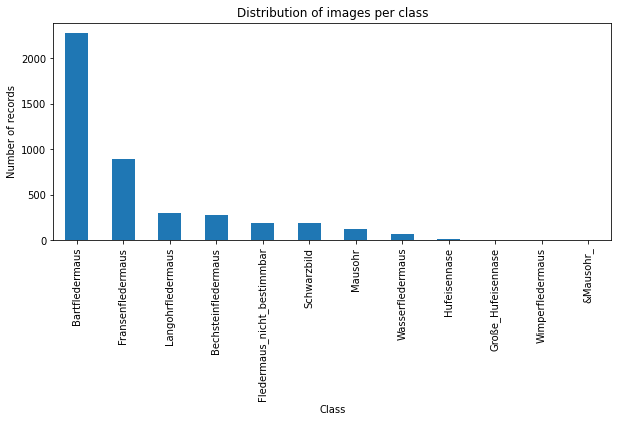

Bartfledermaus                 2275
Fransenfledermaus               892
Langohrfledermaus               292
Bechsteinfledermaus             274
Fledermaus_nicht_bestimmbar     183
Schwarzbild                     182
Mausohr                         124
Wasserfledermaus                 70
Hufeisennase                     10
Große_Hufeisennase                3
Wimperfledermaus                  3
&Mausohr_                         1
Name: new_species, dtype: int64


In [10]:
#create a df from each csv file
df_labels_1 = pd.read_csv(src_labels_1, header=0, delimiter=";")
df_labels_2 = pd.read_csv(src_labels_2, header=0, delimiter=";")
df_labels_3 = pd.read_csv(src_labels_3, header=0, delimiter=";")

df = pd.concat([df_labels_1, df_labels_2, df_labels_3], ignore_index = True) #connect dataframes

#add image-paths to dataframe and remove blanks within the labels
df["new_filename"] = destination + "/" + df['ID'].astype(str)+ ".png"
df["new_species"] = df["Species"].replace(to_replace=' ', value='_', regex=True)

#reconcile labels and images, to make sure a image to every label exists (else, delete label)
df = df[df['ID'].astype(str).isin(cleaned)]

#print dataframe to identifie inappropriate classes
print(f'DataFrame contains {len(df)} records')
plot_col(df, "new_species")
print(df["new_species"].value_counts())


## 4.2. Remove classes, if not applicable or inappropriate
- remove "Schwarzbilder", because we don't know how they are defined
- remove "großen Hufeisennase", "Hufeisennase" und "Wimperfledermaus", because classes are too small
- remove "nicht bestimmbaren Fledermäuse", because of missing labels
- remove "&Mausohr_", because of typo

Cleaned DataFrame contains 3927 records
Cleaned DataFrame contains 6 classes


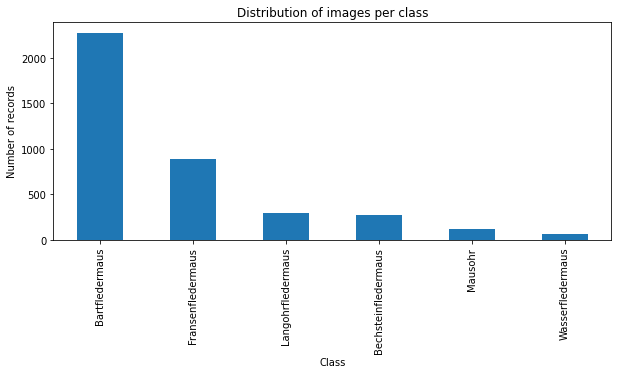

Bartfledermaus         2275
Fransenfledermaus       892
Langohrfledermaus       292
Bechsteinfledermaus     274
Mausohr                 124
Wasserfledermaus         70
Name: new_species, dtype: int64


In [11]:
#remove data without label and very small groups (judgemental)
df = df.loc[~(df['new_species'] == "Schwarzbild"),:]
df = df.loc[~(df['new_species'] == "Fledermaus_nicht_bestimmbar"),:]
df = df.loc[~(df['new_species'] == "Große_Hufeisennase"),:]
df = df.loc[~(df['new_species'] == "Hufeisennase"),:]
df = df.loc[~(df['new_species'] == "Wimperfledermaus"),:]
df = df.loc[~(df['new_species'] == "&Mausohr_"),:]

number_classes = df["new_species"].nunique() #Count classes, for use in module

#check
print(f'Cleaned DataFrame contains {len(df)} records')
print(f'Cleaned DataFrame contains {number_classes} classes')
plot_col(df, "new_species")
print(df["new_species"].value_counts())

#df.to_csv("cleaned_df.csv") #save copy of cleaned df

## 4.3. Splitt dataframe into train-, validation and test-data

In [12]:
#train test split to create train, validation and test df
train, val_test_df = train_test_split(
    df, stratify=df["new_species"], test_size=0.2, shuffle=True)
validation, test = train_test_split(
    val_test_df, stratify=val_test_df["new_species"], test_size=0.5, shuffle=True)

#set to true to show train, validation and test df
print_dfs = False 
if print_dfs:
    plot_col(train, "new_species")
    plot_col(validation, "new_species")
    plot_col(test, "new_species")
    print(train["new_species"].value_counts())
    print(validation["new_species"].value_counts())
    print(test["new_species"].value_counts())

# 5. Resampling
- Reduce / eliminate the data inbalance by downsampling and upsampling

## 5.1. Downsampling
- remove data from the largest group ("Bartfledermaus"), to match second largest group
- by removing data from the largest group, we reduce the inbalance of the data and therefore have to create less augmented images in step 4.2. Upsampling
- by downsampling, we reduce the final training-dataframe. 
- although some data will not be used, we will also reduce the training run-time.

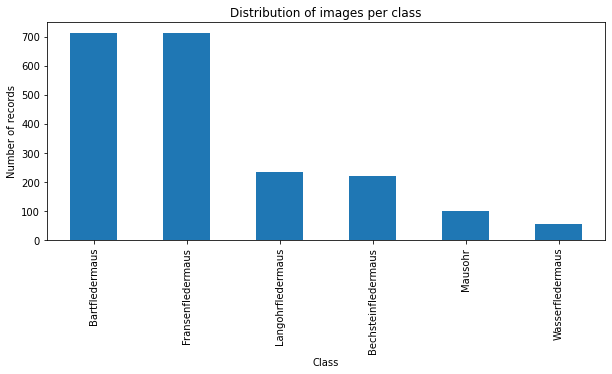

Bartfledermaus         713
Fransenfledermaus      713
Langohrfledermaus      234
Bechsteinfledermaus    219
Mausohr                 99
Wasserfledermaus        56
Name: new_species, dtype: int64


In [14]:
train_downsampled = downsample_data(train, "new_species") #run downsampling function
train = train_downsampled #set new dataframe to train df

#checking counts
plot_col(train, "new_species")
print(train["new_species"].value_counts())

## 5.2. Upsampling
- creating new augmented data, to reduce / eliminate data-inbalance using AugLy

https://github.com/facebookresearch/AugLy  
    "blur": imaugs.Blur(radius=3),  
    "random_noise": imaugs.RandomNoise(mean=0.1, var=0.2),  
    "sharpen": imaugs.Sharpen(factor=10),  
    "encoding_quality": imaugs.EncodingQuality(quality=15),  
    "change_aspect_ratio": imaugs.ChangeAspectRatio(ratio=3.0),  
    "opacity": imaugs.Opacity(level=0.5),  
    "pixelization": imaugs.Pixelization(ratio=0.3),  
    "scale": imaugs.Scale(factor=0.5),  
    "color_jitter": imaugs.ColorJitter(brightness_factor=1.6,contrast_factor=1.6,saturation_factor=1.6,),  
    "hflip": imaugs.HFlip(),  
    "perspective_transform": imaugs.PerspectiveTransform(),  
    "rotate": imaugs.Rotate(degrees=50),  
    "vflip": imaugs.VFlip(),    
    "overlay_text": imaugs.OverlayText(font_size=0.5, x_pos=0.2, y_pos=0.1),  
    "overlay_stripes": imaugs.OverlayStripes(line_angle=-30,
        line_density=0.9,
        line_width=0.4,
        line_type="dashed"

Bartfledermaus         1820
Wasserfledermaus        713
Mausohr                 713
Bechsteinfledermaus     713
Fransenfledermaus       713
Langohrfledermaus       713
Name: new_species, dtype: int64


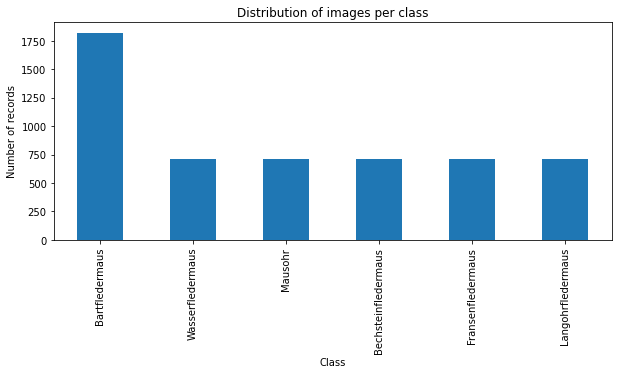

In [13]:
#set to true to run test and show some augmented images
display_image = False

if display_image:
    #create dummy df for the first 5 labels, to show augmentations
    df_dummy = train.loc[:5,:]   
    print(df_dummy)
 
    dummy_upsample_data = upsample_data(df_dummy,"new_species", destination)
    dummy_df_augs = pd.DataFrame(dummy_upsample_data, columns=["new_species","new_filename"])
    dummy_df_ups = pd.concat([dummy_df_augs, df_dummy[["new_species", "new_filename"]]], axis=0)
    train = dummy_df_ups #set new dataframe to train df
else:      
    upsample_data = upsample_data(train,"new_species", destination) #run upsampling function
    df_augs = pd.DataFrame(upsample_data, columns=["new_species","new_filename"]) #Create index
    df_ups = pd.concat([df_augs, train[["new_species", "new_filename"]]], axis=0) #conect df_augs and train
    train = df_ups.sample(frac=1).reset_index(drop=True) #set new dataframe to train df and shuffle

#check
print(train["new_species"].value_counts())
plot_col(train, "new_species")
#print(train)

#save copy of train dataframe
#train.to_csv("training_data_upsampled.csv")

In [137]:
# Get class balances
import torch
import sklearn
def get_class_balance():
    """returns the tensor of the class distribtion"""
    lst = []
    data = train["new_species"].to_list()
    
    """for  number in data:
        lst.append(number)"""
    values = np.array(data)
    
    
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight= "balanced",
                    classes = np.unique(values),
                    y = values)
    return torch.tensor(class_weights,dtype=torch.float)
loss_weights = get_class_balance()


In [19]:
### Custom Resdiual block
from torch import nn
class block1(nn.Module):
    def __init__(self,num_features,num_classes ):
        super(block1, self).__init__()
        #self.first_layer = nn.Linear(num_features, num_features),
        self.secound_layer = nn.ReLU(nn.Linear(num_features, num_features))
        
        self.final_layer = nn.ReLU(nn.Linear(num_features, num_classes))

    def forward(self,x):
        residual = x
        print(x)
        #print(self.first_layer)
        #out = self.first_layer(x)
        out = self.secound_layer(x)
        out += residual
        result = self.final_layer(out)
        
        
        
        return result

In [20]:
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from functools import partial

from torch import nn

from flash.core.registry import FlashRegistry  # noqa: F401

from flash.image.classification.heads import IMAGE_CLASSIFIER_HEADS

# define ImageClassifier registry



def custom_head(num_features: int, num_classes: int) -> nn.Module:
    """Loads a linear head.

    Args:
        num_features: Number of input features.
        num_classes: Number of output classes.

    Returns:
        nn.Module: Linear head.

    """
    x = num_features
    new_head = nn.Sequential(
      nn.Linear(num_features, num_features),
      nn.ReLU(),
      nn.Linear(num_features, num_features),
      nn.ReLU(),
      nn.Linear(num_features, num_classes)
    )
    return new_head

def resudal_layer(num_features: int, num_classes: int) -> nn.Module:
    """Loads a linear head.

    Args:
        num_features: Number of input features.
        num_classes: Number of output classes.

    Returns:
        nn.Module: Linear head.

    """
    
    return block1(num_features,num_classes)
IMAGE_CLASSIFIER_HEADS(
    partial(custom_head),
    name="custom_2_layer",
)
IMAGE_CLASSIFIER_HEADS(
    partial(resudal_layer),
    name="residual",
)


functools.partial(<function resudal_layer at 0x7ff43cdff8b0>)

In [1]:
heads = ImageClassifier.available_heads()
back = ImageClassifier.available_backbones()



NameError: name 'ImageClassifier' is not defined

# 6. Define and train model
## 6.1. Create logger
- add TensorBoardLogger and CSV-Logger to evaluate the model
- Acces TensorBoardLogger: http://localhost:6006/

In [24]:
#create logger
class Tparams:
    epochs=40
    batch_size=15
    backbone="resnet50"   #densenet161
    strategy= "freeze" #("unfreeze_milestones",((10, 20), 2))
    resample_augmentation="stripes_opac" #no impact. Just for output to hyperparams
    test_run_name=f"ds_y:ups_{resample_augmentation}+25%:freeze:epo{epochs}:{backbone}"
tparams = Tparams()
tb_logger = TensorBoardLogger("tb_logs", name=tparams.test_run_name, log_graph=False,
        default_hp_metric=True,
        flush_secs=5)
csv_logger = CSVLogger("csv_logs", name=tparams.test_run_name)

#log aditional variables in hyperparams
csv_logger.log_hyperparams(tparams.__dict__)
#csv_logger.log_metrics(lr_monitor.__dict__)

#add callbacks
early_stop_callback = EarlyStopping(monitor="val_cross_entropy", patience=10, verbose=True, mode="min")
lr_monitor = LearningRateMonitor(logging_interval='epoch') 
ckpt_callback = ModelCheckpoint(
    dirpath='ckpt_logs',
    monitor= None,
    mode= 'min',
    every_n_train_steps= 0,
    every_n_epochs= 1,
    train_time_interval= None,
    save_on_train_epoch_end= True,
    )

functools.partial(<function custom_head at 0x7fb13d76a700>)

Epoch 7:  14%|█▍        | 54/386 [00:28<02:56,  1.88it/s, loss=0.096, v_num=1, train_accuracy_step=0.933, train_cross_entropy_step=0.101, val_accuracy=0.817, val_cross_entropy=0.777, train_accuracy_epoch=0.948, train_cross_entropy_epoch=0.145]

## 6.2. Run model
PyTorch Lightning https://lightning-flash.readthedocs.io/_/downloads/en/0.2.3/pdf/

        Copyright The PyTorch Lightning team.  

        Licensed under the Apache License, Version 2.0 (the "License");  
        you may not use this file except in compliance with the License.  
        You may obtain a copy of the License at  

             http://www.apache.org/licenses/LICENSE-2.0  

        Unless required by applicable law or agreed to in writing, software  
        distributed under the License is distributed on an "AS IS" BASIS,  
        WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
        See the License for the specific language governing permissions and  
        limitations under the License.

In [26]:
import torch
datamodule = AudioClassificationData.from_data_frame(
    input_field="new_filename",
    target_fields="new_species",
    train_data_frame = train,
    val_data_frame = validation,
    test_data_frame = test,
    predict_data_frame = test,
    transform_kwargs=dict(spectrogram_size=(128, 128)),
    batch_size=tparams.batch_size,
    num_workers=14  #int(os.cpu_count()),
)
ImageClassifier.heads = IMAGE_CLASSIFIER_HEADS
model = ImageClassifier(
    num_classes=number_classes, 
    backbone=tparams.backbone, 
    head="linear",
    labels=datamodule.labels,
    pretrained=True,
    #loss_fn=torch.nn.CrossEntropyLoss(loss_weights)
)



trainer = flash.Trainer(
    max_epochs=tparams.epochs,
    logger=[tb_logger,csv_logger],
    log_every_n_steps=1,
    gpus=torch.cuda.device_count(),
    #move_metrics_to_cpu=True,
    #auto_lr_find=True,
    accumulate_grad_batches=2,
    enable_progress_bar=True,
    callbacks=[early_stop_callback,lr_monitor,ckpt_callback],
)

trainer.finetune(model, datamodule=datamodule, strategy=tparams.strategy)
trainer.save_checkpoint("audio_classification_model.pt")
trainer.test(dataloaders=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/wustl/VideoClassifier/.menv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/wustl/bats_classification/ckpt_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | train_metrics | ModuleDict     | 0     
1 | val_metrics   | ModuleDict     | 0     
2 | test_metrics  | ModuleDict     | 0     
3 | adapter       | DefaultAdapter | 23.5 M
-------------------------------------------------
65.4 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.081    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 386/386 [00:28<00:00, 13.61it/s, loss=0.603, v_num=3, train_accuracy_step=0.867, train_cross_entropy_step=0.603, val_accuracy=0.761, val_cross_entropy=0.695]

Metric val_cross_entropy improved. New best score: 0.695


Epoch 1: 100%|██████████| 386/386 [00:28<00:00, 13.44it/s, loss=0.529, v_num=3, train_accuracy_step=0.800, train_cross_entropy_step=0.530, val_accuracy=0.796, val_cross_entropy=0.655, train_accuracy_epoch=0.655, train_cross_entropy_epoch=0.942]

Metric val_cross_entropy improved by 0.039 >= min_delta = 0.0. New best score: 0.655


Epoch 2: 100%|██████████| 386/386 [00:27<00:00, 13.89it/s, loss=0.492, v_num=3, train_accuracy_step=0.867, train_cross_entropy_step=0.278, val_accuracy=0.807, val_cross_entropy=0.588, train_accuracy_epoch=0.808, train_cross_entropy_epoch=0.556] 

Metric val_cross_entropy improved by 0.068 >= min_delta = 0.0. New best score: 0.588


Epoch 4: 100%|██████████| 386/386 [00:29<00:00, 13.15it/s, loss=0.293, v_num=3, train_accuracy_step=0.800, train_cross_entropy_step=0.412, val_accuracy=0.850, val_cross_entropy=0.533, train_accuracy_epoch=0.869, train_cross_entropy_epoch=0.370] 

Metric val_cross_entropy improved by 0.055 >= min_delta = 0.0. New best score: 0.533


Epoch 14: 100%|██████████| 386/386 [00:31<00:00, 12.09it/s, loss=0.144, v_num=3, train_accuracy_step=1.000, train_cross_entropy_step=0.0329, val_accuracy=0.779, val_cross_entropy=0.871, train_accuracy_epoch=0.957, train_cross_entropy_epoch=0.122]  

Monitored metric val_cross_entropy did not improve in the last 10 records. Best score: 0.533. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 386/386 [00:32<00:00, 11.88it/s, loss=0.144, v_num=3, train_accuracy_step=1.000, train_cross_entropy_step=0.0329, val_accuracy=0.779, val_cross_entropy=0.871, train_accuracy_epoch=0.954, train_cross_entropy_epoch=0.125]


/home/wustl/VideoClassifier/.menv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/wustl/bats_classification/ckpt_logs/epoch=14-step=2700.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/wustl/bats_classification/ckpt_logs/epoch=14-step=2700.ckpt


Testing DataLoader 0: 100%|██████████| 27/27 [00:00<00:00, 44.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7888040542602539
   test_cross_entropy       0.8000063300132751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.7888040542602539,
  'test_cross_entropy': 0.8000063300132751}]

In [ ]:
## Use pytorch lighting to adjust 
for p in model.parameters()[:-2]:
        p.requires_grad = False

# 7. Predict and evaluate results
## 7.1. Plot accuracy and loss
- Plot the results of the training and validation run using the CSV-Logger

In [ ]:
#trainer.tune(model=model)
#trainer.fit(model=model)
trainer.tune(model=model, datamodule=datamodule) #ohne "=model"?

csv_logs/ds_y:ups_stripes_opac+25%:freeze:epo40:resnet50/version_3
Index(['lr-Adam', 'step', 'train_accuracy_step', 'train_cross_entropy_step',
       'epoch', 'val_accuracy', 'val_cross_entropy', 'train_accuracy_epoch',
       'train_cross_entropy_epoch', 'test_accuracy', 'test_cross_entropy'],
      dtype='object')


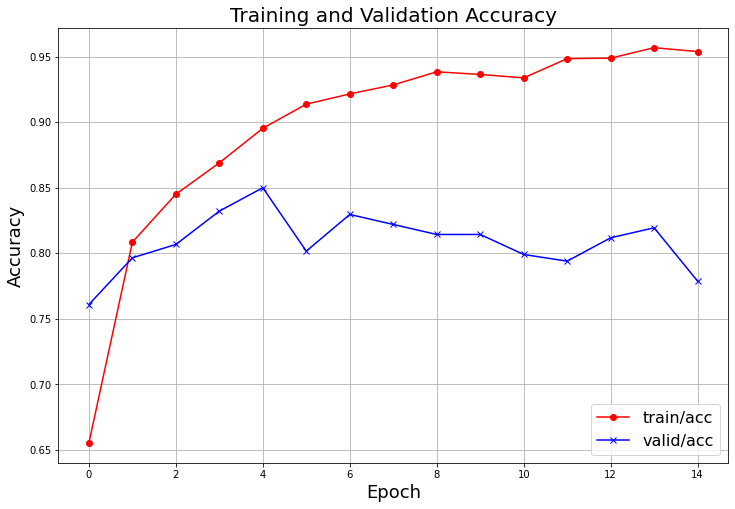

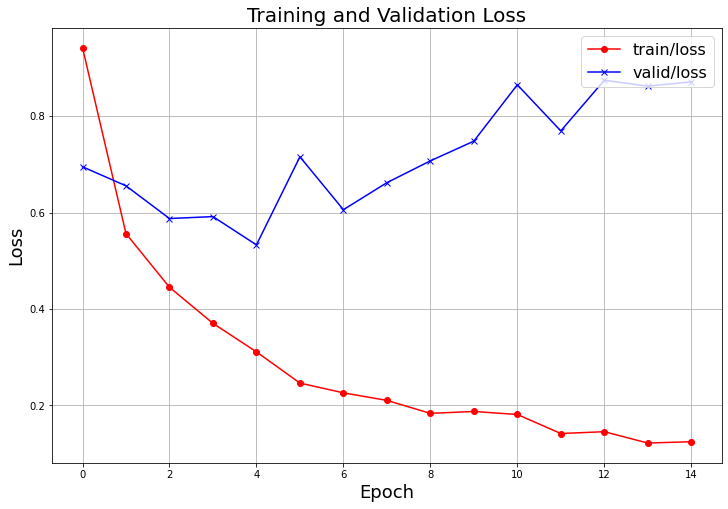

In [27]:
#get metrics from CSVLogger
print(csv_logger.log_dir)
metrics = pd.read_csv(f'{csv_logger.log_dir}/metrics.csv')
print(metrics.columns)

train_acc = metrics['train_accuracy_epoch'].dropna().reset_index(drop=True)
valid_acc = metrics['val_accuracy'].dropna().reset_index(drop=True)
train_loss = metrics['train_cross_entropy_epoch'].dropna().reset_index(drop=True)
valid_loss = metrics['val_cross_entropy'].dropna().reset_index(drop=True)

plot_model_acc(train_acc=train_acc, valid_acc=valid_acc, save_dir=csv_logger.log_dir)
plot_model_loss(train_loss=train_loss, valid_loss=valid_loss, save_dir=csv_logger.log_dir)

## 7.2. Predict test-data
- generate predictions from test-data created in step 4.3.

In [28]:
unique_classes = test['new_species'].unique() #create list of classes for confusion matrix
labels = trainer.predict(model, datamodule=datamodule, output="labels") #run predictions
preds = [ll for label in labels for ll in label] #convert to vector
target = test["new_species"].to_list() #set targets for test prediction

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 27/27 [00:07<00:00, -41.69it/s]   


## 7.3. Confusion-Matrix
- generate confusion-matrix from the predictions of the test-data

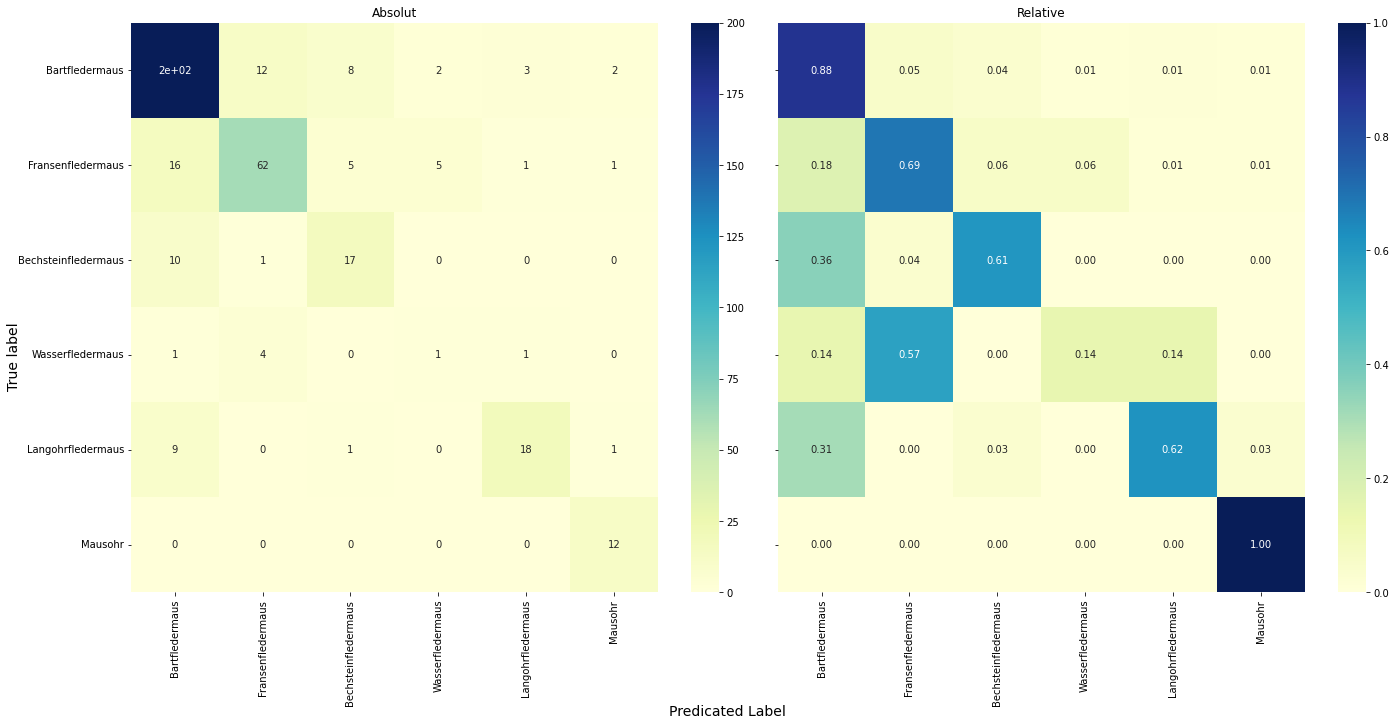

Bartfledermaus         227
Fransenfledermaus       90
Langohrfledermaus       29
Bechsteinfledermaus     28
Mausohr                 12
Wasserfledermaus         7
Name: new_species, dtype: int64


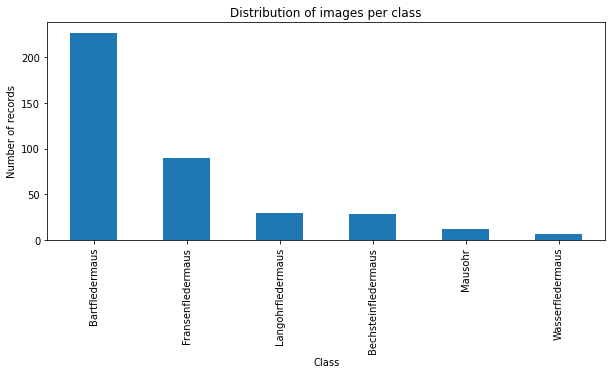

In [29]:
#create confusion marrix and plot
cm = confusion_matrix(y_true=target, y_pred=preds, labels=unique_classes)
plot_confusion_matrix(cm=cm, classes=unique_classes, save_dir=csv_logger.log_dir)

#check
#print values per class of test df to check ticklabels
print(test["new_species"].value_counts())
plot_col(test, "new_species")

In [ ]:
configure_optimizers()

def configure_optimizers(self):
    gen_opt = Adam(self.model_gen.parameters(), lr=0.01)
    gen_sch = {
        'scheduler': ExponentialLR(gen_opt, 0.99),
        'interval': 'epoch'  # called after each training step
    }
    dis_sch = CosineAnnealing(dis_opt, T_max=10) # called every epoch
    return [gen_opt], [gen_sch]

In [ ]:
import math

start_lr = 0.0001
exp_decay = 0.1

def scheduler(epoch):
    return start_lr * math.exp(-exp_decay*epoch)

scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_finder(model, datamodule=datamodule)

# Results can be found in
print(lr_finder)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr

# Fit model
trainer.fit(model, datamodule=datamodule)

# 8. Information cells

In [ ]:
av_backbones = ImageClassifier.available_backbones()
print(av_backbones)

av_heads = ImageClassifier.available_heads()
print(av_heads)

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
%pwd
%cd /Users/eliaskirchberger/Documents/Master/StatL_Learning

In [ ]:
%tensorboard --helpfull

In [ ]:
%tensorboard --logdir tb_logs

In [ ]:
%lsmagic
%whos

In [ ]:
help(AudioClassificationData)# --help
#flash image_classification --help

# Unused

In [ ]:
#https://learnopencv.com/tensorboard-with-pytorch-lightning/
#https://www.pytorchlightning.ai/blog/tensorboard-with-pytorch-lightning
%load ext tensorboard
%tensorboard --logdir tb_logs/
# logging using tensorboard logger
#self.logger.experiment.add_scalar("Loss/Train",avg_loss,self.current_epoch)